In [1]:
import pandas as pd
import numpy as np
import time_series_transform.base as base
from time_series_transform.time_series_transformer import *
from sklearn.preprocessing import StandardScaler
import scipy
from time_series_transform.tensorflow_adopter import *

In [3]:
df = pd.read_csv('./Data/Stock/sp.csv')
df = df.sort_values('Date')
df= df.drop('Date',axis =1)
df

,Open,High,Low,Close,Adj Close,Volume
0,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
1,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
3,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
4,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000
...,...,...,...,...,...,...
5156,3105.919922,3128.439941,3101.169922,3115.860107,3115.860107,4443130000
5157,3143.639893,3165.810059,3124.520020,3130.010010,3130.010010,4190830000
5158,3155.290039,3182.590088,3155.290039,3179.719971,3179.719971,4736450000
5159,3166.439941,3184.149902,3142.929932,3145.320068,3145.320068,4563700000


In [4]:
df = df.dropna()
df = pd.DataFrame(df.to_records())
df = df.drop('index',axis =1)

In [5]:
def first_difference(df,label):
    df[f'{label}_lag1']=df[label].shift(1)
    df[f'Diff_{label}'] = df[label]-df[f'{label}_lag1']
    return df
df = first_difference(df,'High')
df = first_difference(df,'Low')
df = first_difference(df,'Open')
df = first_difference(df,'Close')

In [6]:
df['High_mvg50'] = df.High.rolling(50).mean()
df['High_mvg200'] = df.High.rolling(200).mean()
df['Low_mvg50'] = df.Low.rolling(50).mean()
df['Low_mvg200'] = df.Low.rolling(200).mean()
df['High_fft'] = np.fft.fft(df.High.values)
df['Low_fft'] = np.fft.fft(df.Low.values)
df['Close_fft'] = np.fft.fft(df.Close.values)
df['Open_fft'] = np.fft.fft(df.Open.values)
df['Volume_fft'] = np.fft.fft(df.Volume.values)
df = df.dropna()

In [7]:
resDf = None
for i in df:
    tmp = pd.DataFrame(df[i]).transpose()
    tmp.columns = map(lambda x: f'{i}_{str(x)}',tmp.columns)
    tmp['merge'] = np.array([0])
    if resDf is None:
        resDf = tmp
    else:
        resDf = resDf.merge(tmp, on = ['merge'])

In [8]:
resDf

,Open_199,Open_200,Open_201,Open_202,Open_203,Open_204,Open_205,Open_206,Open_207,Open_208,...,Volume_fft_5151,Volume_fft_5152,Volume_fft_5153,Volume_fft_5154,Volume_fft_5155,Volume_fft_5156,Volume_fft_5157,Volume_fft_5158,Volume_fft_5159,Volume_fft_5160
0,1374.170044,1374.619995,1349.969971,1342.130005,1388.76001,1396.930054,1395.780029,1398.130005,1364.900024,1364.439941,...,1.184392e+11-3.583532e+11j,4.117844e+11-3.175527e+11j,-9.981340e+10-3.003119e+11j,4.482362e+11-2.047702e+11j,-1.701796e+11-1.008210e+12j,4.242559e+11-1.955758e+11j,3.714791e+11-1.030745e+12j,-5.401204e+11+2.512636e+11j,1.635839e+12-2.006339e+12j,-2.608224e+12-2.233216e+12j


In [9]:
trainDate = list(range(199,2000))
valDate = list(range(2000,2600))
testDate = list(range(2600,3200))
labels = [
#     'Close',
#     'Open',
#     'High',
    'Diff_High',
    'Diff_Low',
    'Diff_Open',
    'Diff_Close',
#     'Low',
#     'Volume',
#     'Adj Close',
#     'High_mvg50',
#     'High_mvg200',
#     'Low_mvg50',
#     'Low_mvg200',
    'High_fft',
    'Open_fft',
    'Close_fft',
    'Low_fft',
#     'Volume_fft'
         ]
WINDOW_SIZE = 400

In [11]:
psd = Pandas_Time_Series_Dataset(resDf)
for i,v in enumerate(labels):
    if i == 0:
        psd.set_config(
            name = f'sequence',
            colNames = list(map(lambda x: f'{v}_{str(x)}',trainDate)),
            tensorType = 'sequence',
            sequence_stack = None,
            isResponseVar = False,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )
    else:
        psd.set_config(
            name = f'{v}_sequence',
            colNames = list(map(lambda x: f'{v}_{str(x)}',trainDate)),
            tensorType = 'sequence',
            sequence_stack = "sequence",
            isResponseVar = False,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )
        
psd.set_config(
    name = 'label',
    colNames = list(map(lambda x: f'High_{str(x)}',trainDate)),
    tensorType = 'label',
    sequence_stack = None,
    isResponseVar = True,
    windowSize = WINDOW_SIZE,
    seqSize = 1837,
    outType = np.float32
)


In [12]:
gen = psd.make_data_generator()
tfg = TFRecord_Writer('abc.tfRecord')
tfg.write_tfRecord(gen)
dtypeRecord_train = tfg.get_tfRecord_dtype()

C:\Users\USER\Documents\Kaggle\M5\time_series_transform\tensorflow_adopter.py:172: ComplexWarning: Casting complex values to real discards the imaginary part
  return _bytes_feature(tf.io.serialize_tensor(value.astype(np.float32)))


In [14]:
psd = Pandas_Time_Series_Dataset(resDf)
for i,v in enumerate(labels):
    if i == 0:
        psd.set_config(
            name = f'sequence',
            colNames = list(map(lambda x: f'{v}_{str(x)}',valDate)),
            tensorType = 'sequence',
            sequence_stack = None,
            isResponseVar = False,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )
    else:
        psd.set_config(
            name = f'{v}_sequence',
            colNames = list(map(lambda x: f'{v}_{str(x)}',valDate)),
            tensorType = 'sequence',
            sequence_stack = "sequence",
            isResponseVar = False,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )
        
psd.set_config(
    name = 'label',
    colNames = list(map(lambda x: f'High_{str(x)}',valDate)),
    tensorType = 'label',
    sequence_stack = None,
    isResponseVar = True,
    windowSize = WINDOW_SIZE,
    seqSize = 1837,
    outType = np.float32
)

In [15]:
gen = psd.make_data_generator()
tfg = TFRecord_Writer('abc_val.tfRecord')
tfg.write_tfRecord(gen)
dtypeRecord_val = tfg.get_tfRecord_dtype()

In [17]:
tfr_train = TFRecord_Reader('abc.tfRecord',dtypeRecord_train)
tfr_val = TFRecord_Reader('abc_val.tfRecord',dtypeRecord_val)

In [18]:
def data_transform(X):
    # we only use the current week day and current price as feature
    # ignore the rest of data within the window since the change is very limited.
    X['current'] = X['sequence'][:,:-28,:]
    X['past'] = X['sequence'][:,-28:,:]
    Y = X['label']
    return (X,Y)

In [19]:
EVALUATION_INTERVAL = 250
Validation_STEP =  250
EPOCHS = 100


train_dataset = tfr_train.make_tfDataset()
val_dataset = tfr_val.make_tfDataset()
batchsize = 1000

train_dataset = train_dataset.shuffle(1000).unbatch().batch(2000).map(data_transform).\
prefetch(tf.data.experimental.AUTOTUNE).repeat()
val_dataset = val_dataset.shuffle(1000).unbatch().batch(2000).map(data_transform).\
prefetch(tf.data.experimental.AUTOTUNE).repeat()

In [20]:
def create_attention_model():
    seq_input = tf.keras.layers.Input(shape=(WINDOW_SIZE,len(labels)),name = 'sequence')
    
    # lstm
#     seq = tf.keras.layers.LayerNormalization()(seq_input)
#     seq = tf.keras.layers.LSTM(5)(seq)
    
    #2d cnn
    seq = tf.keras.layers.Reshape((20,20,len(labels)))(seq_input)
    seq = tf.keras.layers.BatchNormalization()(seq)
    seq = tf.keras.layers.Conv2D(5,(11,11),activation = 'relu')(seq)
    seq = tf.keras.layers.MaxPooling2D((2,2))(seq)
    seq = tf.keras.layers.BatchNormalization()(seq)
    seq = tf.keras.layers.Conv2D(5,(2,2),activation = 'relu')(seq)
    seq = tf.keras.layers.MaxPooling2D((2,2))(seq)
    
    #1d cnn
#     seq = tf.keras.layers.BatchNormalization()(seq_input)
#     seq = tf.keras.layers.Conv1D(5,3,activation = 'relu')(seq)
#     seq = tf.keras.layers.MaxPooling1D(2)(seq)    


    seq = tf.keras.layers.Flatten()(seq)
    seq = tf.keras.layers.Dense(10,'elu')(seq)
    seq = tf.keras.layers.Dropout(0.2)(seq)
    seq = tf.keras.layers.Dense(5,'elu')(seq)
    seq = tf.keras.layers.Dense(1)(seq)
    

    
    lstm_embed = tf.keras.models.Model({
        "sequence":seq_input
                                       },
                                       seq)

    rmse = tf.keras.metrics.RootMeanSquaredError()
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    huber = tf.keras.losses.Huber()
    adam = tf.keras.optimizers.Adam(lr = 0.1,
                                    decay = 0.01,
                                    amsgrad = True
                                   )
    rmsp = tf.keras.optimizers.RMSprop(learning_rate=0.05, 
                                       rho=0.9)


    lstm_embed.compile(optimizer=adam, 
                       loss='mse',
                       metrics = ['mae','mse',rmse
                                 ]
                      )
    return lstm_embed

In [21]:
model = create_attention_model()
tf.keras.utils.plot_model(
    model, show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

{'item_id': {'colNames': 'item_id',
  'tensorType': 'category',
  'param': {'windowSize': 0, 'batchSize': 254, 'outType': numpy.float32},
  'sequence_stack': None,
  'responseVariable': False},
 'dept_id': {'colNames': 'dept_id',
  'tensorType': 'category',
  'param': {'windowSize': 0, 'batchSize': 254, 'outType': numpy.float32},
  'sequence_stack': None,
  'responseVariable': False},
 'cat_id': {'colNames': 'cat_id',
  'tensorType': 'category',
  'param': {'windowSize': 0, 'batchSize': 254, 'outType': numpy.float32},
  'sequence_stack': None,
  'responseVariable': False},
 'store_id': {'colNames': 'store_id',
  'tensorType': 'category',
  'param': {'windowSize': 0, 'batchSize': 254, 'outType': numpy.float32},
  'sequence_stack': None,
  'responseVariable': False},
 'state_id': {'colNames': 'state_id',
  'tensorType': 'category',
  'param': {'windowSize': 0, 'batchSize': 254, 'outType': numpy.float32},
  'sequence_stack': None,
  'responseVariable': False}}

In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    min_delta=0.001, 
    patience=50, 
    verbose=1, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)
model.fit(train_dataset,
          epochs=500,
          verbose = 2,
          validation_data = val_dataset,
          validation_steps=1,
          steps_per_epoch=10,
          callbacks= [early_stopping]
     )

Train for 10 steps, validate for 1 steps
Epoch 1/500
10/10 - 8s - loss: 1312990.5437 - mae: 1125.7487 - mse: 1312990.5000 - root_mean_squared_error: 1145.8580 - val_loss: 52109968.0000 - val_mae: 6894.1255 - val_mse: 52109968.0000 - val_root_mean_squared_error: 7218.7236
Epoch 2/500
10/10 - 6s - loss: 219601.9703 - mae: 386.2849 - mse: 219601.9531 - root_mean_squared_error: 468.6171 - val_loss: 72153960.0000 - val_mae: 8024.6074 - val_mse: 72153960.0000 - val_root_mean_squared_error: 8494.3486
Epoch 3/500
10/10 - 6s - loss: 87572.0398 - mae: 235.2517 - mse: 87572.0391 - root_mean_squared_error: 295.9257 - val_loss: 42321664.0000 - val_mae: 6083.0063 - val_mse: 42321664.0000 - val_root_mean_squared_error: 6505.5103
Epoch 4/500
10/10 - 6s - loss: 70509.0371 - mae: 209.8017 - mse: 70509.0391 - root_mean_squared_error: 265.5354 - val_loss: 22806182.0000 - val_mae: 4386.9971 - val_mse: 22806182.0000 - val_root_mean_squared_error: 4775.5820
Epoch 5/500
10/10 - 7s - loss: 58708.2414 - mae: 18

KeyboardInterrupt: 

In [28]:
prd = model.predict(train_dataset,steps = 1)
val_prd = model.predict(val_dataset, steps=1)

In [29]:
def plot_diff(prcd,resDf,label):
    real = resDf[list(map(lambda x: f'High_{x}',label))].transpose().values
    plotDf = pd.DataFrame(real).tail(len(prcd))
    print(plotDf.shape)
    plotDf['prd_High'] = prcd
    return plotDf

(1401, 1)


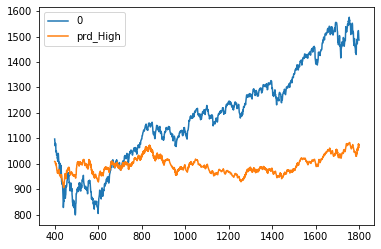

In [30]:
plotDf = plot_diff(prd,resDf,trainDate)
plotDf.plot()

(200, 1)


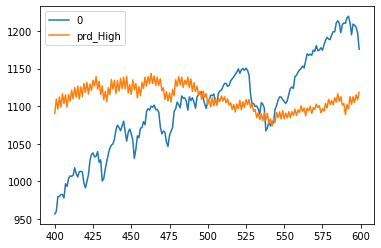

In [31]:
plotDf = plot_diff(val_prd,resDf,valDate)
plotDf.plot()

In [32]:
tpsd = Pandas_Time_Series_Dataset(resDf)
for i,v in enumerate(labels):
    if i == 0:
        tpsd.set_config(
            name = f'sequence',
            colNames = list(map(lambda x: f'{v}_{str(x)}',testDate)),
            tensorType = 'sequence',
            sequence_stack = None,
            isResponseVar = False,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )
    else:
        tpsd.set_config(
            name = f'{v}_sequence',
            colNames = list(map(lambda x: f'{v}_{str(x)}',testDate)),
            tensorType = 'sequence',
            sequence_stack = "sequence",
            isResponseVar = False,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )
        
tpsd.set_config(
    name = 'label',
    colNames = list(map(lambda x: f'High_{str(x)}',testDate)),
    tensorType = 'label',
    sequence_stack = None,
    isResponseVar = True,
    windowSize = WINDOW_SIZE,
    seqSize = 1837,
    outType = np.float32
)

In [33]:
tgen = psd.make_data_generator()
test_prediction = model.predict(tgen)

(200, 1)


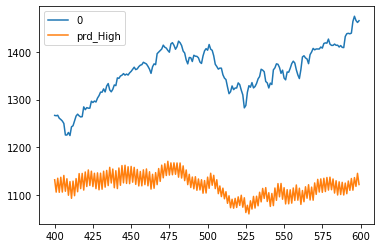

In [34]:
plotDf = plot_diff(test_prediction,resDf,testDate)
plotDf.plot()

In [108]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(plotDf[0],plotDf.prd_High))

201.150094542275

In [56]:
resDf

,Open_199,Open_200,Open_201,Open_202,Open_203,Open_204,Open_205,Open_206,Open_207,Open_208,...,Volume_fft_5151,Volume_fft_5152,Volume_fft_5153,Volume_fft_5154,Volume_fft_5155,Volume_fft_5156,Volume_fft_5157,Volume_fft_5158,Volume_fft_5159,Volume_fft_5160
0,1374.170044,1374.619995,1349.969971,1342.130005,1388.76001,1396.930054,1395.780029,1398.130005,1364.900024,1364.439941,...,1.184392e+11-3.583532e+11j,4.117844e+11-3.175527e+11j,-9.981340e+10-3.003119e+11j,4.482362e+11-2.047702e+11j,-1.701796e+11-1.008210e+12j,4.242559e+11-1.955758e+11j,3.714791e+11-1.030745e+12j,-5.401204e+11+2.512636e+11j,1.635839e+12-2.006339e+12j,-2.608224e+12-2.233216e+12j


In [11]:
psd = Pandas_Time_Series_Dataset(resDf)
psd.set_config(
    name = f'sequence',
    colNames = ['Open_199','Open_200','Open_201','Open_202'],
    tensorType = 'label',
    sequence_stack = None,
    isResponseVar = True,
    windowSize = 2,
    seqSize = 1837,
    outType = np.float32
)
psd.set_config(
    name = f'sequence2',
    colNames = ['Open_199','Open_200','Open_201','Open_202'],
    tensorType = 'label',
    sequence_stack = 'sequence',
    isResponseVar = False,
    windowSize = 2,
    seqSize = 1837,
    outType = np.float32
)

In [12]:
gen = psd.make_data_generator()
for i in gen:
    print(i)

({}, array([[[1349.969971, 1349.969971],
        [1342.130005, 1342.130005]]]))
